### From FHIR Data to Balanced Neural Network BRCA Subtype Predictions
1. Loading [TCGA-BRCA](https://portal.gdc.cancer.gov/projects/TCGA-BRCA) cohort's [Fast Healthcare Interoperability Resources (FHIR)](https://hl7.org/fhir/) Phenotype Data with [GRaph Integration Platform (GRIP)](https://bmeg.github.io/grip/docs/) 
2. Dimensionality Reduction with Autoencoder
3. Classify Subtypes with Multimodel Nueral Network (with model evaluation and prediction)
4. Improve Model to a Balanced Multimodal Neural Network Training (with model evaluation and prediction)
6. Pathway enrichment analysis on Subtype's Model Features
7. Applying GDC Trained Model to METABRIC for Cross-Dataset Subtype Prediction (short demo)
8. Conclusion
   - **Recap**:
    - FHIR schema and grip enabled loading well-structured data.
    - Autoencoder reduced data dimensionality while preserving key features.
    - A balanced multimodal neural network, trained with SMOTETomek, improved classification accuracy for all subtypes.
   - **Highlight**:
    - Domain-specific expertise played a critical role in subtype classification. 
    - In precision medicine, classifying cancer subtypes is essential for actionable insights and better outcomes. 
    - This approach bridges biological data and AI, empowering robust subtype prediction workflows and empowering better treatment decisions in real-world scenarios.

In [20]:
import os
import sys
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import umap
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score


from imblearn.combine import SMOTETomek

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim

from tensorflow.keras.callbacks import ReduceLROnPlateau

seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import warnings
import logging

warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.stderr = open(os.devnull, 'w')

tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
warnings.filterwarnings("ignore", category=FutureWarning)

#### 1. GRIP query on TCGA-BRCA FHIR Data
- Extracting breast cancer subtypes and associated patients from TCGA-BRCA FHIR transformed data

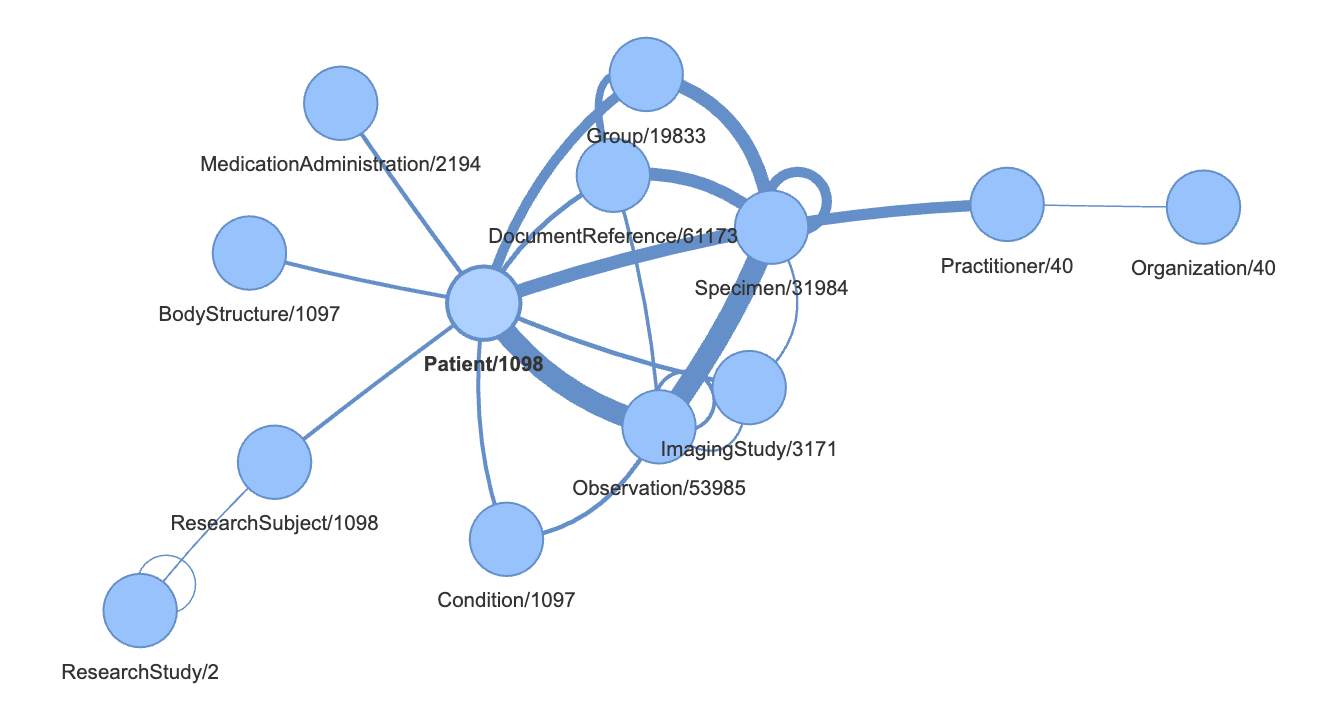

In [2]:
from IPython.display import Image
Image("../img/TCGA-BRCA-FHIRized.png", width=850) 

In [3]:
import gripql

conn = gripql.Connection("http://localhost:8201")
G = conn.graph("gdc_brca")
G.query().V().hasLabel("Patient").execute()[:1] # look at structure.

[{'gid': '28cd8c4a-2a0a-5090-8ee1-52cc2a9df946',
  'label': 'Patient',
  'data': {'deceasedBoolean': False,
   'extension': [{'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-birthsex',
     'valueCode': 'F'},
    {'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-race',
     'valueString': 'white'},
    {'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity',
     'valueString': 'not hispanic or latino'},
    {'url': 'http://hl7.org/fhir/SearchParameter/patient-extensions-Patient-age',
     'valueQuantity': {'value': 58}}],
   'gender': 'female',
   'id': '28cd8c4a-2a0a-5090-8ee1-52cc2a9df946',
   'identifier': [{'system': 'https://gdc.cancer.gov/case_submitter_id',
     'use': 'secondary',
     'value': 'TCGA-BH-A0W3'},
    {'system': 'https://gdc.cancer.gov/case_id',
     'use': 'official',
     'value': '3c612e12-6de8-44fa-a095-805c45474821'}],
   'resourceType': 'Patient'}}]

In [4]:
subtypes = G.query().V().hasLabel("Observation").as_("observation").unwind("$.code").unwind("$.code.coding").has(gripql.eq("$.code.coding.code", "NCIT_C185941")).execute()
subtypes_patients = G.query().V().hasLabel("Observation").as_("observation").unwind("$.code").unwind("$.code.coding").has(gripql.eq("$.code.coding.code", "NCIT_C185941")).out("focus_Patient").execute()

In [5]:
def expand_metadata(patient_data) -> dict:
    exts = patient_data.get('extension', [])
    race = next((ext.get('valueString') for ext in exts if 'us-core-race' in ext.get('url', '')), None)
    ethnicity = next((ext.get('valueString') for ext in exts if 'us-core-ethnicity' in ext.get('url', '')), None)
    age = next((ext.get('valueQuantity', {}).get('value') for ext in exts if 'Patient-age' in ext.get('url', '')), None)
    
    idents = patient_data.get('identifier', [])
    secondary_identifier = next((iden.get('value') for iden in idents if iden.get('use') == 'secondary'), None)
    official_identifier = next((iden.get('value') for iden in idents if iden.get('use') == 'official'), None)
    
    return {
        'id': patient_data.get('id'),
        'official_identifier': official_identifier,
        'secondary_identifier': secondary_identifier,
        'gender': patient_data.get('gender'),
        'race': race,
        'ethnicity': ethnicity,
        'age': age,
        'deceased': patient_data.get('deceasedBoolean')
    }

# create a data frame for phenotypic data
df_pheno = pd.DataFrame([expand_metadata(dat['data']) for dat in subtypes_patients])
df_pheno['age'] = pd.to_numeric(df_pheno['age'], errors='coerce').fillna(0).astype(np.int64)

l = []
for item in subtypes:
    if 'valueString' in item['data'].keys():
        l.append(item['data']['valueString'])
df_pheno['subtype'] = l
# df_pheno[["secondary_identifier", "subtype", "gender", "race",	"ethnicity", "age", "deceased"]]
df_pheno[["secondary_identifier", "subtype"]] # this demo's focus is on subtypes

secondary_identifier subtype
0           TCGA-3C-AAAU    LumA
1           TCGA-3C-AALI    Her2
2           TCGA-3C-AALJ    LumB
3           TCGA-3C-AALK    LumA
4           TCGA-4H-AAAK    LumA
..                   ...     ...
990         TCGA-WT-AB44    LumA
991         TCGA-XX-A899    LumA
992         TCGA-XX-A89A    LumA
993         TCGA-Z7-A8R5    LumA
994         TCGA-Z7-A8R6    LumB

[995 rows x 2 columns]

In [6]:
print("Loading normalized mRNA expressions on TCGA-BRCA GDC samples...")
df_gdc = pd.read_csv("../data/TMP_20230209/BRCA_v12_20210228.tsv", sep="\t")
df_gdc = df_gdc[(~df_gdc.iloc[:, 2:].isna().all(axis=1)) & (~(df_gdc.iloc[:, 2:] == 0).all(axis=1))]
expression_cols = [col for col in df_gdc.columns if 'GEXP' in col]
df_gdc = df_gdc[['BRCA', 'Labels'] + expression_cols]
df_gdc.columns = [col.split(":")[3] if ':' in col else col for col in df_gdc.columns]

if df_gdc.columns.duplicated().any():
    print("Duplicate columns detected in GDC data. Removing duplicates...")
    df_gdc = df_gdc.loc[:, ~df_gdc.columns.duplicated()]

print("Joining grip query result on BRCA subtype's with normalized mRNA expressions...")
df_pheno.rename(columns={"secondary_identifier": "BRCA"}, inplace=True)
df_gdc = df_gdc.merge(df_pheno[['BRCA', 'subtype']], on='BRCA', how='left')
df_gdc.drop('Labels', axis=1, inplace=True)
df_gdc.rename(columns={"subtype": "Labels"}, inplace=True)
df_gdc.index = df_gdc.BRCA
demo_order = ['Labels'] + list(df_gdc.columns[3:10])

Loading normalized mRNA expressions on TCGA-BRCA GDC samples...
Duplicate columns detected in GDC data. Removing duplicates...
Joining grip query result on BRCA subtype's with normalized mRNA expressions...


EDA - Evaluating data distribution...
Labels
LumA     535
LumB     205
Basal    175
Her2      80
Name: count, dtype: int64


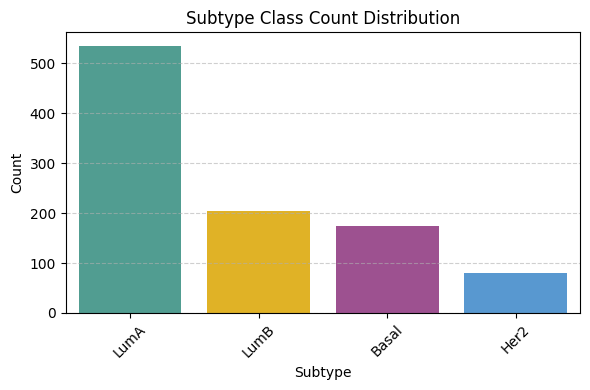

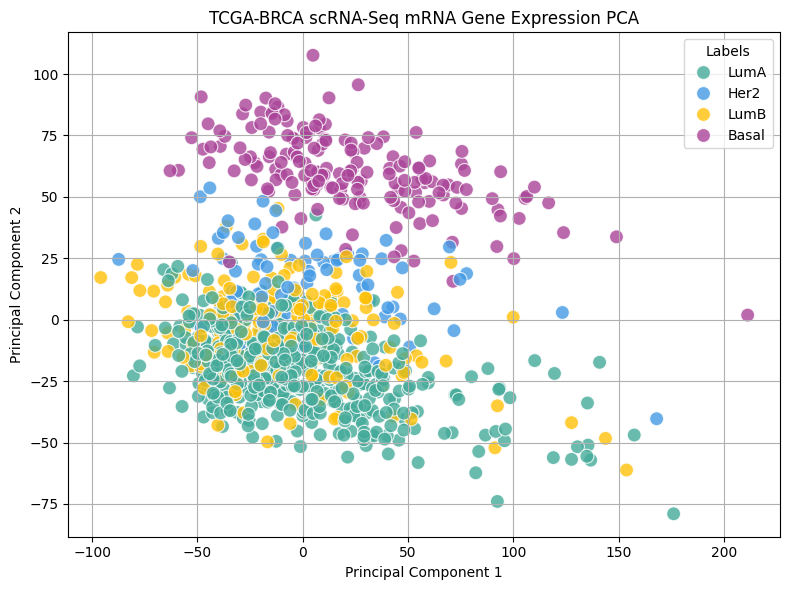

In [7]:
subtype_colors = {
    "LumA": "#44AA99",  
    "LumB": "#FFC107",  
    "Basal": "#AA4499", 
    "Her2": "#449AE4"   
}

print("EDA - Evaluating data distribution...")
count_per_label = df_gdc['Labels'].value_counts()
print(count_per_label)
plt.figure(figsize=(6, 4))
sns.barplot(x=count_per_label.index, y=count_per_label.values, palette=[subtype_colors[label] for label in count_per_label.index])
plt.title("Subtype Class Count Distribution", fontsize=12)
plt.xlabel("Subtype", fontsize=10), plt.ylabel("Count", fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# PCA on TCGA-BRCA normalized mRNA GDC Data
gene_expression_cols = df_gdc.drop(columns=["Labels", "BRCA"]).columns  
df_gdc_scaled = df_gdc[['Labels'] + list(gene_expression_cols)].copy()

scaler = StandardScaler()
df_gdc_scaled[gene_expression_cols] = scaler.fit_transform(df_gdc_scaled[gene_expression_cols])
pca = PCA(n_components=3)
df_gdc_scaled[['PCA1', 'PCA2', 'PCA3']] = pca.fit_transform(df_gdc_scaled[gene_expression_cols])

# 2D PCA 
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_gdc_scaled, x='PCA1', y='PCA2', hue='Labels', palette=subtype_colors, s=100, alpha=0.8)
plt.title("TCGA-BRCA scRNA-Seq mRNA Gene Expression PCA")
plt.xlabel("Principal Component 1"), plt.ylabel("Principal Component 2")
plt.legend(title='Labels', loc='upper right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# # 3D PCA w plotly
# fig = px.scatter_3d(df_gdc_scaled, x='PCA1', y='PCA2', z='PCA3', color='Labels',
#                      title="TCGA-BRCA scRNA-Seq 3D PCA Visualization",
#                      labels={"PCA1": "Principal Component 1", "PCA2": "Principal Component 2", "PCA3": "Principal Component 3"},
#                      opacity=0.8, width=1200, height=900, color_discrete_map=subtype_colors)

# fig.update_traces(marker=dict(size=8))
# fig.show()

- Luminal A and Luminal B are both classified as hormone receptor-positive (HR+), meaning they express estrogen and progesterone receptors. 
- Luminal A is usually HER2-negative while Luminal B may be HER2-positive, which can impact treatment options. 
- Basal tumors lack estrogen receptors, making them "triple negative" (ER-, PR-, HER2-) while Luminal cancers are typically hormone receptor positive (ER+) and have a better outlook with hormone therapy options.

#### 2. Dimensionality Reduction with Autoencoder
- Reduce feature dimensionality while preserving key molecular characteristics.
- Autoencoders compress the high-dimensional data into a more efficient representation.

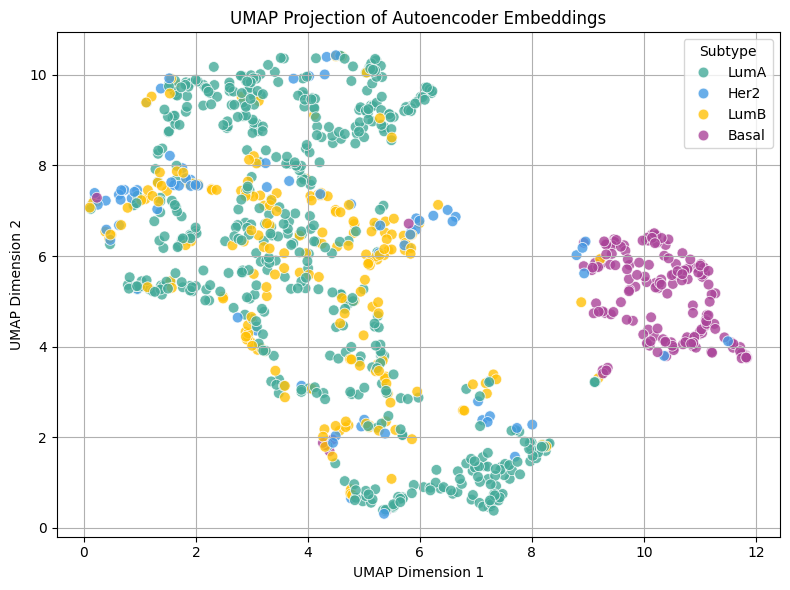

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16, deep=False):
        super().__init__()
        enc_layers = [nn.Linear(input_dim, 512), nn.ReLU(), nn.Linear(512, 128), nn.ReLU()] if deep else [nn.Linear(input_dim, 128), nn.ReLU()]
        dec_layers = [nn.Linear(128, 512), nn.ReLU(), nn.Linear(512, input_dim)] if deep else [nn.Linear(128, input_dim)]
        self.encoder = nn.Sequential(*enc_layers, nn.Linear(128, encoding_dim), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(encoding_dim, 128), nn.ReLU(), *dec_layers, nn.Sigmoid())

    def forward(self, x):
        return self.decoder(self.encoder(x))

        
def generate_embeddings(X, input_dim, encoding_dim=16, epochs=50, lr=0.001):
    model = Autoencoder(input_dim, encoding_dim, deep=False)
    criterion, optimizer = nn.MSELoss(), optim.Adam(model.parameters(), lr=lr)
    X_tensor = torch.tensor(X.values, dtype=torch.float32)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = criterion(model(X_tensor), X_tensor)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        return model.encoder(X_tensor).numpy()

gene_expression_cols = df_gdc_scaled.drop(columns=[col for col in ["Labels", "BRCA"] if col in df_gdc_scaled.columns]).columns
input_dim = len(gene_expression_cols)
embeddings = generate_embeddings(df_gdc_scaled[gene_expression_cols], input_dim)
embedding_cols = [f"Dim{i+1}" for i in range(16)]
df_gdc_scaled[embedding_cols] = embeddings
df_gdc_scaled["UMAP1"], df_gdc_scaled["UMAP2"] = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings).T

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_gdc_scaled, x="UMAP1", y="UMAP2", hue="Labels", palette=subtype_colors, s=60, alpha=0.8)
plt.title("UMAP Projection of Autoencoder Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Subtype")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 3. Classify Subtypes with Multimodel Nueral Network
- When classifying data into multiple subtype categories, only one subtype can be assigned to each patient/specimen data point.
    - softmax formula which is an activation for the multi-class scenario
    - loss='categorical_crossentropy': produces a one-hot array containing the probable match for each category 
- If one class is overrepresented or underrepresented, it might skew the model’s performance. Demo class imbalance in cancer subtype data (ex. Her2 is underrepresented).

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6594 - f1_score: 0.5168 - loss: 1.2764 - val_accuracy: 0.8188 - val_f1_score: 0.7718 - val_loss: 1.0477
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9141 - f1_score: 0.8652 - loss: 0.3273 - val_accuracy: 0.8500 - val_f1_score: 0.8039 - val_loss: 0.9441
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9204 - f1_score: 0.8925 - loss: 0.3254 - val_accuracy: 0.8750 - val_f1_score: 0.8237 - val_loss: 0.8913
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9539 - f1_score: 0.9263 - loss: 0.1654 - val_accuracy: 0.8562 - val_f1_score: 0.8205 - val_loss: 0.9565
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9728 - f1_score: 0.9385 - loss: 0.1357 - val_accuracy: 0.8875 - val_f1_score: 0.8872 - val_loss: 0.7037
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9857 - f1_score: 0.9630 - loss: 0.0311 - val_accuracy: 0.8687 - val_f1_score: 0.8256 - val_loss

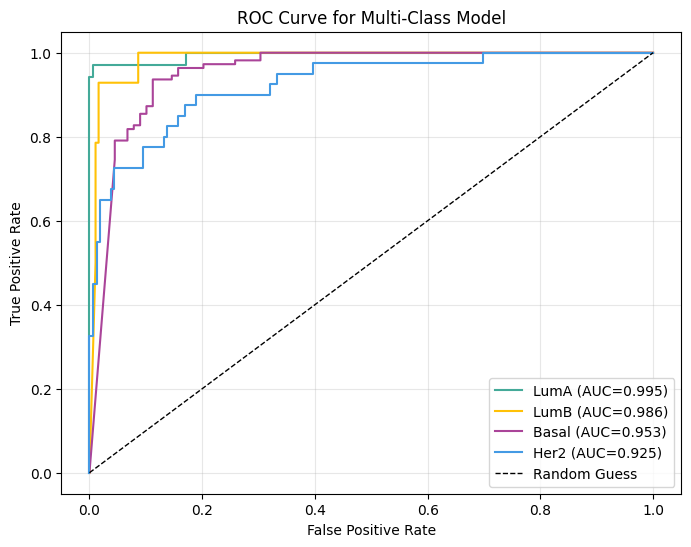

In [10]:
class_maps = {0:"LumA",1:"LumB",2:"Basal",3:"Her2"}
X = df_gdc_scaled.drop(columns=[col for col in ["Labels", "BRCA"] if col in df_gdc_scaled.columns]).apply(pd.to_numeric, errors='coerce').fillna(0)
y = df_gdc['Labels'].astype('category').cat.codes
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
y_train,y_test=to_categorical(y_train,num_classes=len(class_maps)),to_categorical(y_test,num_classes=len(class_maps))

@tf.function(reduce_retracing=True)
def f1_score(y_true, y_pred):
    """f1-score as a custom metric in Keras"""
    y_pred = K.round(y_pred) 
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    precision = tp / (K.sum(K.cast(y_pred, 'float'), axis=0) + K.epsilon())
    recall = tp / (K.sum(K.cast(y_true, 'float'), axis=0) + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1) 


def nn_multiclass_model(optimizer='adam', dropout_rate=0.2, hidden_units=64):
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)), 
        Dropout(dropout_rate),
        Dense(hidden_units, activation='relu'),
        Dense(len(class_maps), activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score], run_eagerly=False)
    return model

model_nn = nn_multiclass_model()
history = model_nn.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_split=0.2)
test_loss, test_accuracy, test_f1 = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.3f}, Test F1-Score: {test_f1:.3f}")

y_pred_proba=model_nn.predict(X_test)
fpr,tpr,roc_auc={}, {},{}
for i in range(len(class_maps)):
    fpr[i],tpr[i],_=roc_curve(y_test[:,i],y_pred_proba[:,i])
    roc_auc[i]=roc_auc_score(y_test[:,i],y_pred_proba[:,i])

plt.figure(figsize=(8,6))
for i, label in class_maps.items():
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC={roc_auc[i]:.3f})', color=subtype_colors[label])
plt.plot([0,1],[0,1],'k--',linewidth=1,label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show() 

#### 4. Improve Model to a Balanced Multimodal Neural Network Training

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7436 - loss: 1.2957 - val_accuracy: 0.9155 - val_loss: 0.9389 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9162 - loss: 0.5372 - val_accuracy: 0.9329 - val_loss: 0.3616 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9478 - loss: 0.2965 - val_accuracy: 0.9271 - val_loss: 0.4012 - learning_rate: 0.0010
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9683 - loss: 0.1596 - val_accuracy: 0.9475 - val_loss: 0.3184 - learning_rate: 0.0010
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9645 - loss: 0.2702 - val_accuracy: 0.9329 - val_loss: 0.8069 - learning_rate: 0.0010
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9648 - loss: 0.4444 - val_accuracy: 0.9592 - val_loss: 0.6680 - learning_rate: 0.0010
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9736 - loss: 0.2701 - val_accuracy:

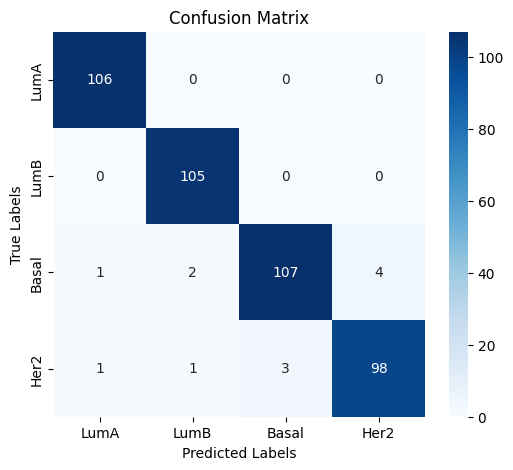

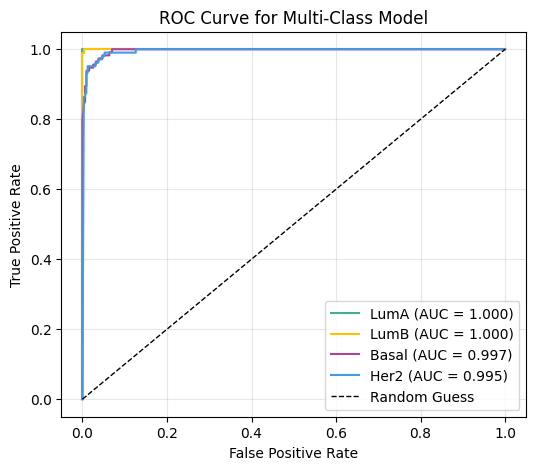

In [11]:
def balance_data(X, y):
    return SMOTETomek(random_state=1234).fit_resample(X, y)

def train_weighted_nn(X_train, y_train, optimizer="adam", dropout_rate=0.3, hidden_units=128, epochs=30):
    class_weights = dict(enumerate(compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)))
    model = Sequential([
        Dense(hidden_units, activation="relu", input_shape=(X_train.shape[1],)), Dropout(dropout_rate),
        Dense(hidden_units, activation="relu"), Dense(len(np.unique(y_train)), activation="softmax")])
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=1, validation_split=0.2, class_weight=class_weights, callbacks=[lr_scheduler])
    return model

def evaluate_model(model, X_test, y_test, class_names, colors):
    from sklearn.metrics import f1_score as sklearn_f1_score

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred_proba = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_proba, axis=1)
    f1 = sklearn_f1_score(y_test, y_pred_labels, average="weighted")
    print(f"\nTest Accuracy: {test_accuracy:.4f}, F1 Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_labels, target_names=class_names))
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix'), plt.xlabel('Predicted Labels'), plt.ylabel('True Labels'), plt.show()

    # roc curve
    y_test_binarized = label_binarize(y_test, classes=np.arange(len(class_names)))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])

    plt.figure(figsize=(6, 5))
    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.3f})', color=colors[class_name])
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="Random Guess")
    plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate"), plt.title("ROC Curve for Multi-Class Model")
    plt.legend(loc="lower right"), plt.grid(alpha=0.3), plt.show()

X_balanced, y_balanced = balance_data(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

model = train_weighted_nn(X_train, y_train)
evaluate_model(model, X_test, y_test, ['LumA', 'LumB', 'Basal', 'Her2'], subtype_colors)

#### 5. Pathway Enrichment Analysis on Subtype-Specific Model Features
- Identify biologically significant pathways associated with subtype classifications.

In [12]:
output_weights = model.get_weights()[-2].T 
input_weights = model.get_weights()[0]  
feature_contributions = np.dot(input_weights, output_weights.T)  
feature_per_subtype_df = pd.DataFrame(feature_contributions, index=X.columns, columns=subtype_colors.keys())
sorted_feature_per_subtype_df = feature_per_subtype_df.apply(lambda x: x.abs().sort_values(ascending=False))

cleaned_df = sorted_feature_per_subtype_df[~sorted_feature_per_subtype_df.index.str.contains("Dim")]
cleaned_df.index = [g.split(":")[3] if ":" in g else g for g in cleaned_df.index]

top_n = 30
for subtype in subtype_colors.keys():
    df = cleaned_df[[subtype]].reset_index().rename(columns={"index": "Feature", subtype: "Importance"}).sort_values(by="Importance", ascending=False)
    df.to_csv(f"../data/subtype_features/{subtype}_feature_contributions.csv", index=False)
    print(f"{subtype}, top {top_n} Features:\n{','.join(df['Feature'].head(top_n))}\n")


LumA, top 30 Features:
MLLT6,ELOVL3,EGOT,PDE4D,SPINK4,RGS7,ACVR1B,GANAB,NDRG4,RGPD1,LBP,ZER1,ABCA5,CHRNB3,GNAT2,MAGEH1,C11orf82,GLDC,C18orf1,SCD,PDIA3P,LHFPL5,CHPT1,C11orf24,PRTG,FSTL3,C5orf20,SLC15A2,WBP2NL,TBC1D3

LumB, top 30 Features:
NGFR,HOXD9,TFAP2B,ODF3L2,C1RL,TNMD,FAM83E,ACCN4,NRIP2,SYT17,AGMAT,HTATIP2,FAM132A,CCNB1,ZNF610,GABRR3,PTTG1,SLC7A3,LOC100131691,FBXO39,F10,PTH,TAC1,PDSS1,POU5F1B,LOC441455,PRHOXNB,FAM72B,TCHH,CHRAC1

Basal, top 30 Features:
PDE4C,SURF1,OSGIN1,OLFM2,KRT6B,SPRR1B,RAP1GAP2,AGR3,TDO2,FAM83C,RASSF10,PPM1J,RHBDL1,TSIX,TSPAN11,STOX2,LRP6,UFD1L,DEFA6,FAM106A,IL20RB,KLK11,LHX8,SV2C,S100A8,ZNF556,CNDP2,MYBPHL,PPY2,IL1A

Her2, top 30 Features:
NR2C1,ZKSCAN2,PPFIBP2,FOXP4,CYFIP1,GDAP1L1,EFNA1,POLR3C,SLC9A4,KRT2,TMEM88,PDE4D,PART1,ZMYM6,NCALD,SFRS6,SUZ12P,C14orf86,CLMN,OR52B6,CALM1,UTP3,SLC32A1,SYT2,CSE1L,FAM157B,DYNLT3,UBE4A,FAM76B,PREX1



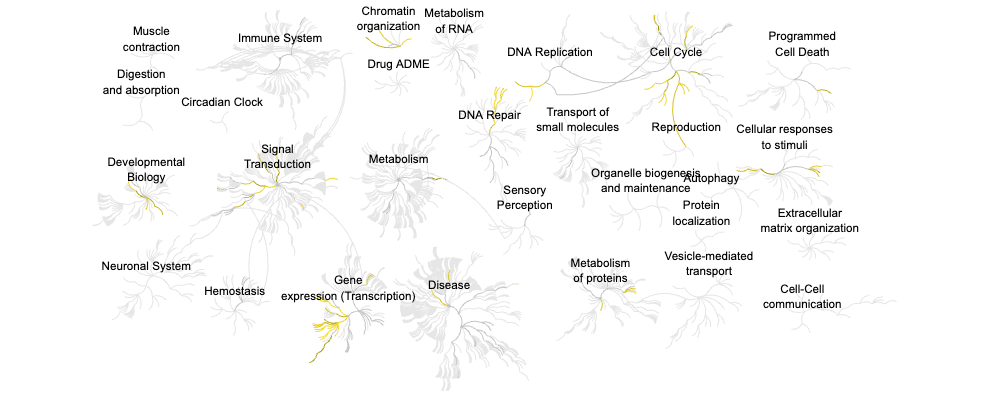

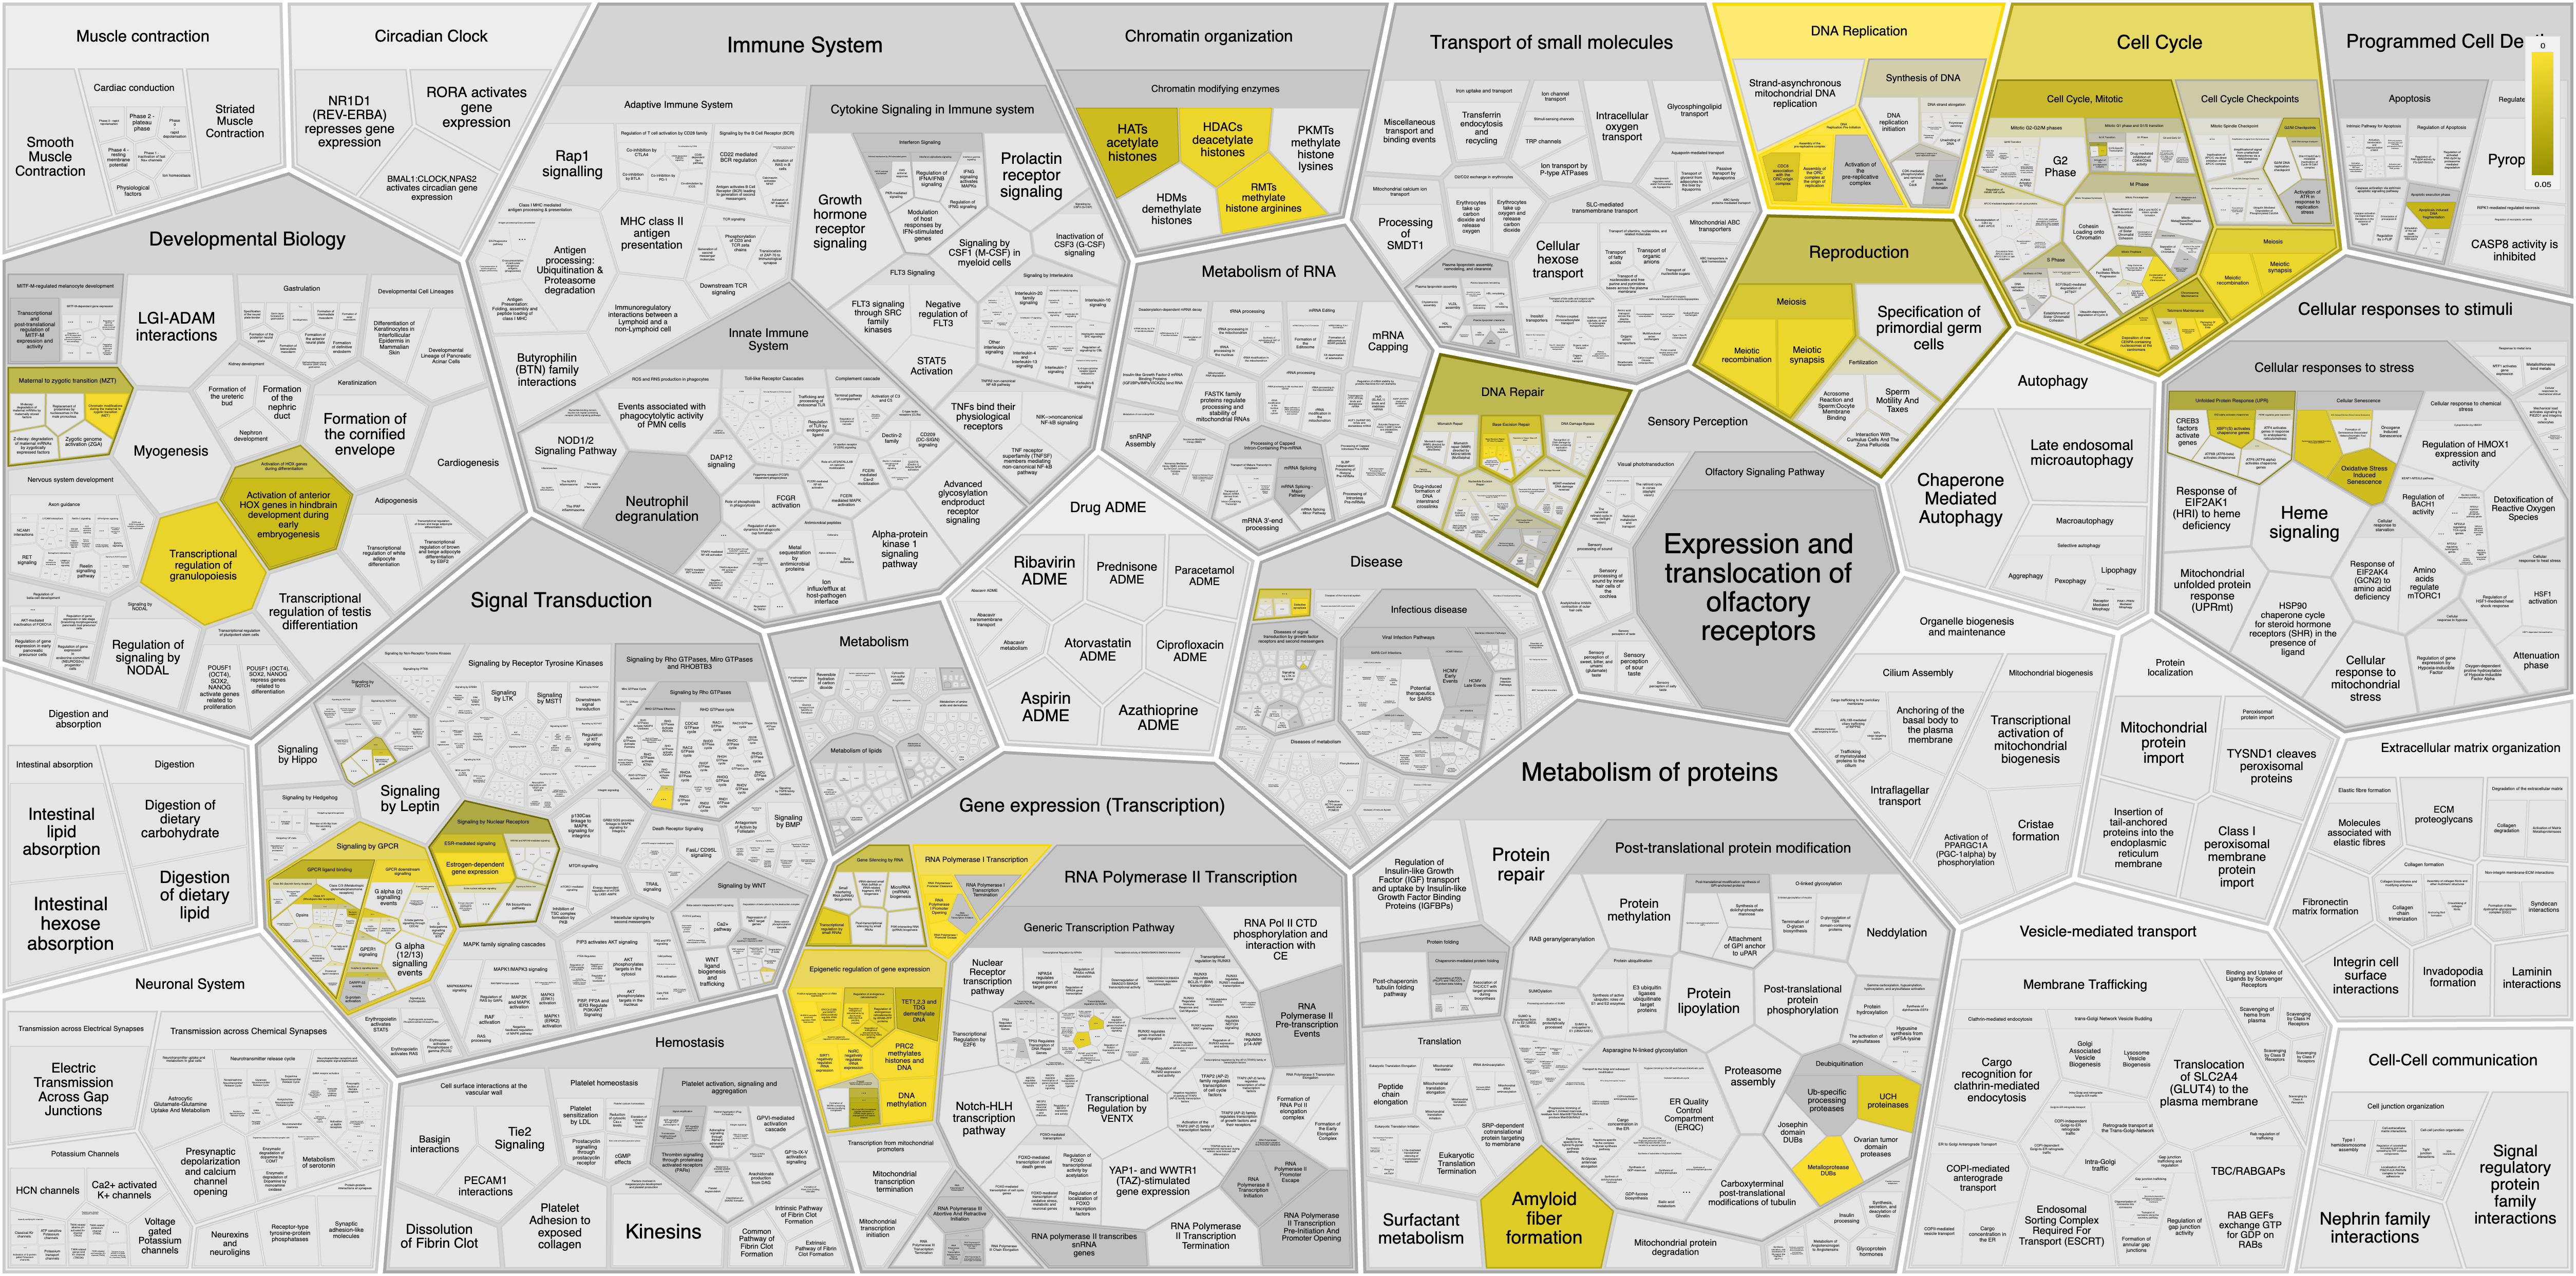

In [13]:
from IPython.display import Image, display
listOfImageNames = ['../img/graph.png',
                    '../img/foam.jpg']
for imageName in listOfImageNames:
    display(Image(filename=imageName))

### 6. Applying GDC Trained Model to METABRIC for Cross-Dataset Subtype Prediction (short demo)
#### 6.1.a Harmonizing mRNA Expression Distributions via Z-Score Normalization for Cross-Dataset Subtype Prediction

In this section, we scale and standardize mRNA expression data from the GDC scRNA-Seq dataset (which includes breast cancer subtype labels) and the METABRIC dataset (without labels). Since the datasets are already normalized (e.g., via log-transformation), we apply Z-Score normalization to align their distributions. This supports downstream analyses and building neural network models that can reliably predict subtypes across differing data resources.

In [14]:
print("Loading and preprocessing METABRIC data...")
metabric_df = pd.read_csv("../data/data_mrna_agilent_microarray.txt", sep="\t", index_col=0)
metabric_df = metabric_df.drop("Entrez_Gene_Id", axis=1).transpose().dropna(axis=1)

# Group by gene names to handle duplicates
metabric_df = metabric_df.T.groupby(level=0).mean().T
genes_intersection = list(set(df_gdc.columns[2:]).intersection(set(metabric_df.columns)))
print(f"Common genes N = {len(genes_intersection)}")

df_gdc = df_gdc[['BRCA', 'Labels'] + genes_intersection]
metabric_df = metabric_df[genes_intersection]

# EDA: trial and error ----------------------------------------------
# df_gdc_log = np.log2(df_gdc[genes_intersection] + 1)
# metabric_df_log = np.log2(metabric_df + 1)
# quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=1234)
# metabric_quantile_normalized = quantile_transformer.fit_transform(metabric_df)
# metabric_quantile_normalized_df = pd.DataFrame(metabric_quantile_normalized, columns=genes_intersection, index=metabric_df.index)

combined_data = pd.concat([df_gdc[genes_intersection], metabric_df[genes_intersection]])
# combined_data = pd.concat([df_gdc_log, metabric_df_log])

print("Fitting scaling...\nData distribution summary: \n")
scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler.fit(combined_data)

# transform GDC and METABRIC data 
# df_gdc_scaled = pd.DataFrame(scaler.transform(df_gdc_log), columns=genes_intersection, index=df_gdc.index)
# metabric_scaled = pd.DataFrame(scaler.transform(metabric_df_log), columns=genes_intersection, index=metabric_df.index)
df_gdc_scaled = pd.DataFrame(scaler.transform(df_gdc[genes_intersection]), columns=genes_intersection, index=df_gdc.index)
# metabric_scaled = pd.DataFrame(scaler.transform(metabric_df[genes_intersection]), columns=genes_intersection, index=metabric_df.index)
metabric_scaled = pd.DataFrame(scaler.fit_transform(metabric_df[genes_intersection]), columns=genes_intersection, index=metabric_df.index)

df_gdc_scaled['Labels'] = df_gdc['Labels']
df_gdc_scaled['BRCA'] = df_gdc['BRCA']

gdc_mean = df_gdc_scaled[genes_intersection].mean().mean()
metabric_mean = metabric_scaled.mean().mean()
gdc_sd = df_gdc_scaled[genes_intersection].std().mean()
metabric_sd = metabric_scaled.std().mean()

print(f"GDC scaled data mean: {gdc_mean:.2f}; sd: {gdc_sd:.2f}")
print(f"METABRIC scaled data mean: {metabric_mean:.2f}; sd: {metabric_sd:.2f}")

Loading and preprocessing METABRIC data...
Common genes N = 17129
Fitting scaling...
Data distribution summary: 

GDC scaled data mean: 0.62; sd: 1.10
METABRIC scaled data mean: -0.00; sd: 1.00


EDA - Evaluating data distributions with PCA....


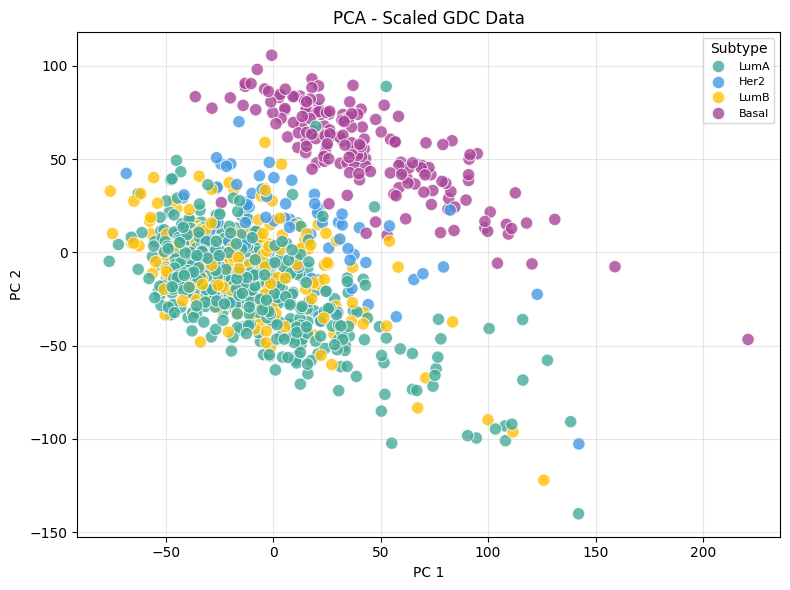

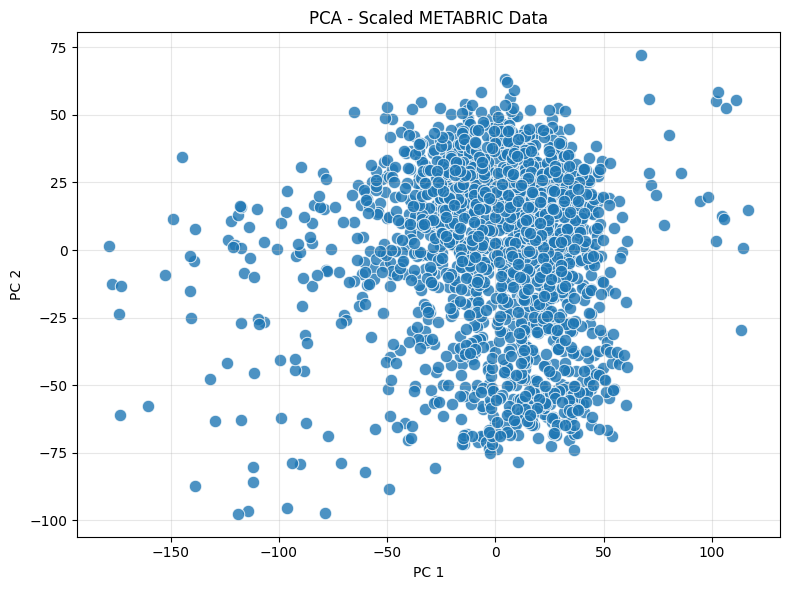

In [15]:
print("EDA - Evaluating data distributions with PCA....")
pca_gdc, pca_metabric = PCA(n_components=2), PCA(n_components=2)

df_gdc_pca = df_gdc_scaled.copy()
df_gdc_pca[['PCA1', 'PCA2']] = pca_gdc.fit_transform(df_gdc_scaled.drop(columns=['Labels', 'BRCA']))

metabric_pca = metabric_scaled.copy()
metabric_pca[['PCA1', 'PCA2']] = pca_metabric.fit_transform(metabric_scaled.drop(columns=['BRCA'], errors='ignore'))

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_gdc_pca, x='PCA1', y='PCA2', hue='Labels', palette=subtype_colors, s=80, alpha=0.8)
plt.title("PCA - Scaled GDC Data", fontsize=12)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title='Subtype', fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(data=metabric_pca, x='PCA1', y='PCA2', palette="viridis", s=80, alpha=0.8)
plt.title("PCA - Scaled METABRIC Data", fontsize=12)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Epoch [10/100], Loss: 1.6164
Epoch [20/100], Loss: 1.6136
Epoch [30/100], Loss: 1.6049
Epoch [40/100], Loss: 1.6002
Epoch [50/100], Loss: 1.5950
Epoch [60/100], Loss: 1.5886
Epoch [70/100], Loss: 1.5798
Epoch [80/100], Loss: 1.5682
Epoch [90/100], Loss: 1.5549
Epoch [100/100], Loss: 1.5288


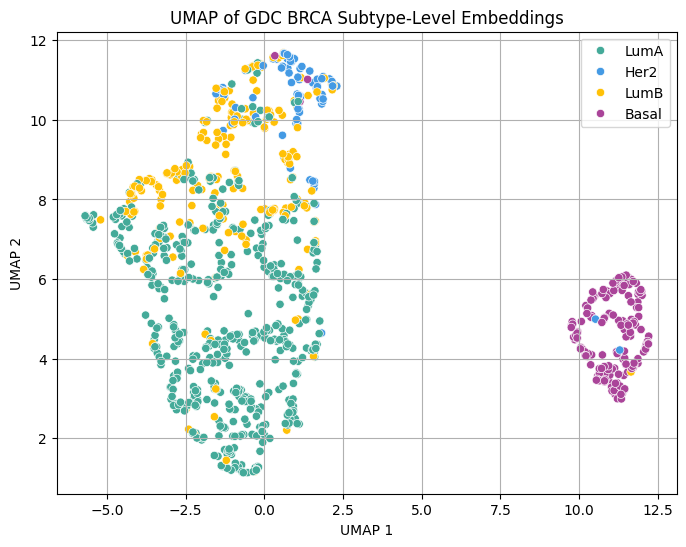

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4992 - loss: 6.6012 - val_accuracy: 0.9242 - val_loss: 0.2100 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8272 - loss: 0.4747 - val_accuracy: 0.9300 - val_loss: 0.2104 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8917 - loss: 0.2863 - val_accuracy: 0.9359 - val_loss: 0.2142 - learning_rate: 0.0010
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9153 - loss: 0.1838 - val_accuracy: 0.9708 - val_loss: 0.1216 - learning_rate: 0.0010
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9458 - loss: 0.1342 - val_accuracy: 0.9417 - val_loss: 0.1546 - learning_rate: 0.0010
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9678 - loss: 0.1018 - val_accuracy: 0.9446 - val_loss: 0.1558 - learning_rate: 0.0010
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9814 - loss: 0.0706 - val_accuracy:

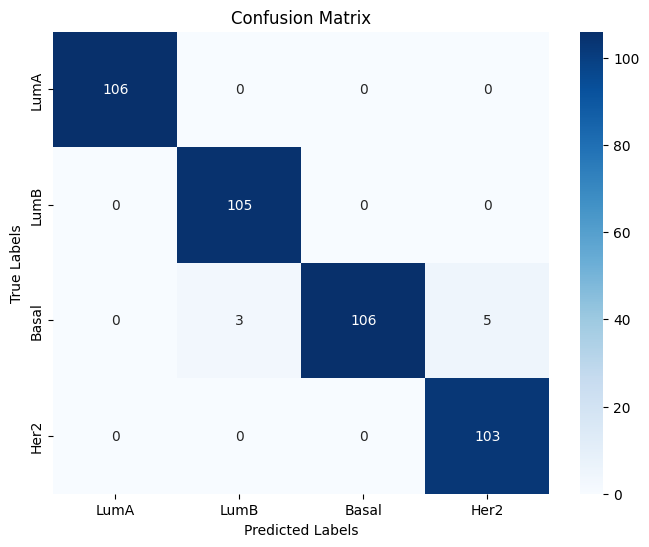

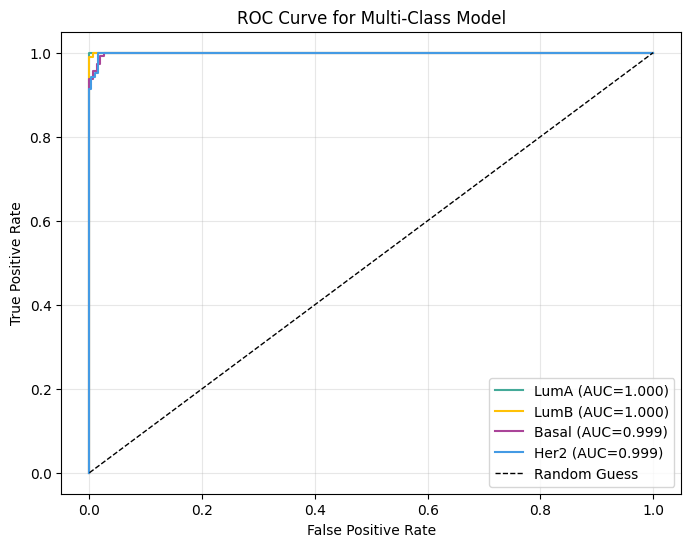

(<matplotlib.legend.Legend at 0x377f9ecd0>, None, None)

In [16]:
# subset w common genes between programs 
genes_intersection = list(set(df_gdc_scaled.columns).intersection(set(metabric_scaled.columns)))
X_gdc_scaled = df_gdc_scaled[genes_intersection]
X_metabric_scaled = metabric_scaled[genes_intersection]

input_dim, encoding_dim = len(genes_intersection), 16
autoencoder = Autoencoder(input_dim, encoding_dim, deep=True)
criterion, optimizer = nn.MSELoss(), optim.Adam(autoencoder.parameters(), lr=0.001)
X_tensor = torch.tensor(X_gdc_scaled.values, dtype=torch.float32)

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = criterion(autoencoder(X_tensor), X_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

embeddings_gdc = autoencoder.encoder(X_tensor).detach().numpy()
embedding_cols = [f"Dim{i+1}" for i in range(encoding_dim)]
df_gdc_scaled[embedding_cols] = embeddings_gdc
subtype_embeddings = df_gdc_scaled.groupby("Labels")[embedding_cols].mean()

umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_model.fit_transform(embeddings_gdc)
df_gdc_scaled['UMAP1'], df_gdc_scaled['UMAP2'] = embeddings_umap[:, 0], embeddings_umap[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_gdc_scaled, x="UMAP1", y="UMAP2", hue="Labels", palette=subtype_colors)
plt.title("UMAP of GDC BRCA Subtype-Level Embeddings")
plt.xlabel("UMAP 1"), plt.ylabel("UMAP 2")
plt.legend(), plt.grid(True), plt.show()

X_train = df_gdc_scaled.drop(columns=["Labels", "BRCA"])
y_train = df_gdc_scaled["Labels"].astype('category').cat.codes

# handle class imbalance 
X_train_balanced, y_train_balanced = SMOTETomek(random_state=1234).fit_resample(X_train, y_train)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

class_weights = dict(enumerate(compute_class_weight(class_weight="balanced", classes=np.unique(y_train_final), y=y_train_final)))

def w_multiclass_model(optimizer="adam", dropout_rate=0.3, hidden_units=128):
    model = Sequential([
        Dense(hidden_units, activation="relu", input_shape=(X_train_final.shape[1],)), 
        Dropout(dropout_rate),
        Dense(hidden_units, activation="relu"),
        Dense(len(np.unique(y_train_final)), activation="softmax")
    ])
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

# train model
model = w_multiclass_model()
history = model.fit(X_train_final, y_train_final, batch_size=32, epochs=30, verbose=1, validation_split=0.2,
                    class_weight=class_weights, callbacks=[ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)])

# evaluate model
test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

y_pred_final = model.predict(X_test_final)
y_pred_labels = np.argmax(y_pred_final, axis=1)
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred_labels, target_names=['LumA', 'LumB', 'Basal', 'Her2']))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_final, y_pred_labels), annot=True, fmt='d', cmap='Blues',
            xticklabels=['LumA', 'LumB', 'Basal', 'Her2'], yticklabels=['LumA', 'LumB', 'Basal', 'Her2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels'), plt.ylabel('True Labels')
plt.show()

y_test_binarized = label_binarize(y_test_final, classes=np.arange(len(['LumA', 'LumB', 'Basal', 'Her2'])))
y_pred_proba = y_pred_final

fpr, tpr, roc_auc = {}, {}, {}
for i, label in enumerate(['LumA', 'LumB', 'Basal', 'Her2']):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])

plt.figure(figsize=(8, 6))
for i, label in enumerate(['LumA', 'LumB', 'Basal', 'Her2']):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC={roc_auc[i]:.3f})', color=subtype_colors[label])
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="Random Guess")
plt.xlabel("False Positive Rate"), plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Model")
plt.legend(loc="lower right"), plt.grid(alpha=0.3), plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

BRCA Subtype Predictions for METABRIC data:
Sample 1: Predicted subtype - Her2
Sample 2: Predicted subtype - LumB
Sample 3: Predicted subtype - Her2
Sample 4: Predicted subtype - LumB
Sample 5: Predicted subtype - Basal
Sample 6: Predicted subtype - Basal
Sample 7: Predicted subtype - LumB
Sample 8: Predicted subtype - Her2
Sample 9: Predicted subtype - LumA
Sample 10: Predicted subtype - LumB


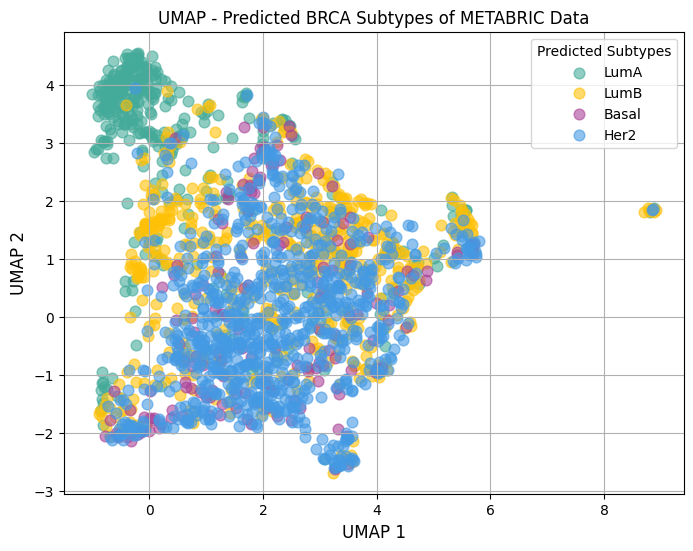

In [17]:
genes_intersection = list(set(df_gdc_scaled.columns).intersection(set(metabric_scaled.columns)))
X_metabric_scaled = metabric_scaled[genes_intersection]

if X_metabric_scaled.shape[1] < 17147:
    dummy_columns = np.zeros((X_metabric_scaled.shape[0], 17147 - X_metabric_scaled.shape[1]))  
    X_metabric_scaled_final = np.hstack((X_metabric_scaled, dummy_columns))  
else:
    X_metabric_scaled_final = X_metabric_scaled 

y_metabric_pred_proba = model.predict(X_metabric_scaled_final)
y_metabric_pred = np.argmax(y_metabric_pred_proba, axis=1)

metabric_labels = {0: "LumA", 1: "LumB", 2: "Basal", 3: "Her2"}
y_metabric_pred_labels = np.array([metabric_labels[label] for label in y_metabric_pred])

print("\nBRCA Subtype Predictions for METABRIC data:")
for i, label in enumerate(y_metabric_pred_labels[:10]):
    print(f"Sample {i+1}: Predicted subtype - {label}")

umap_metabric = umap.UMAP(n_components=2, random_state=42)
X_umap_metabric = umap_metabric.fit_transform(X_metabric_scaled_final)

umap_df = pd.DataFrame(X_umap_metabric, columns=["UMAP1", "UMAP2"])
umap_df["Predicted Subtype"] = y_metabric_pred_labels

plt.figure(figsize=(8, 6))
for subtype, color in subtype_colors.items():
    mask = y_metabric_pred_labels == subtype
    plt.scatter(umap_df.loc[mask, "UMAP1"], umap_df.loc[mask, "UMAP2"], 
                color=color, label=subtype, alpha=0.6, s=60)

plt.title("UMAP - Predicted BRCA Subtypes of METABRIC Data", fontsize=12)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.legend(title="Predicted Subtypes")
plt.grid(True)
plt.show()

pca = PCA(n_components=3)
X_metabric_pca = pca.fit_transform(X_metabric_scaled_final)
pca_df = pd.DataFrame(X_metabric_pca, columns=["PC1", "PC2", "PC3"])
pca_df["Predicted Subtype"] = y_metabric_pred_labels

# fig = px.scatter_3d(pca_df,x="PC1",y="PC2",z="PC3",color="Predicted Subtype",color_discrete_map=subtype_colors,  
#     title="PCA - Predicted BRCA Subtypes of METABRIC Data",
#     labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"},
#     width=1200,height=900)
# fig.show()

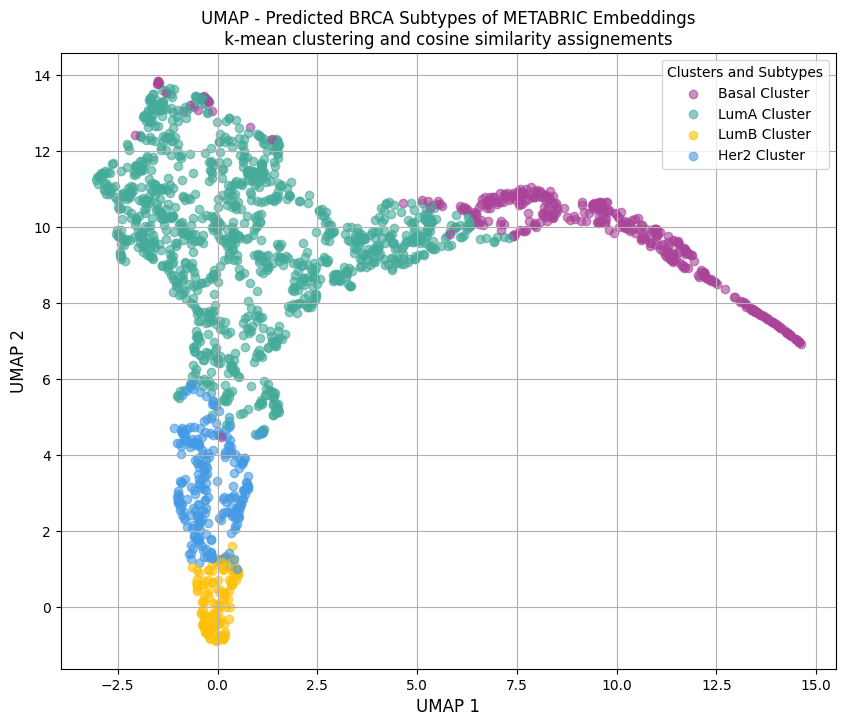

In [18]:
color_map = {
    "LumA": "#44AA99",  
    "LumB": "#FFC107",  
    "Basal": "#AA4499", 
    "Her2": "#449AE4"   
}

metabric_tensor = torch.tensor(metabric_scaled.values, dtype=torch.float32)
embeddings_metabric = autoencoder.encoder(metabric_tensor).detach().numpy()

n_clusters = 4
kmeans_metabric = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters_metabric = kmeans_metabric.fit_predict(embeddings_metabric)
class_maps = {0: "LumA", 1: "LumB", 2: "Basal", 3: "Her2"}
cluster_centers = kmeans_metabric.cluster_centers_ # centroid of each cluster

# compute the centroids of the known subtypes - using mean embeddings of the subtypes
subtype_centroids = {}
for cluster_num in range(n_clusters):
    cluster_indices = np.where(predicted_clusters_metabric == cluster_num)[0]
    cluster_embeddings = embeddings_metabric[cluster_indices]
    mean_embedding = np.mean(cluster_embeddings, axis=0)
    subtype_centroids[cluster_num] = mean_embedding

# find the closest subtype centroid - based on cosine similarity
cluster_labels = []
for cluster_center in cluster_centers:
    distances = {label: cosine_similarity([cluster_center], [centroid])[0][0] for label, centroid in subtype_centroids.items()}
    closest_label = min(distances, key=distances.get)
    cluster_labels.append(closest_label)

# map predicted clusters to corresponding labels
predicted_labels_metabric = [cluster_labels[cluster] for cluster in predicted_clusters_metabric]

# UMAP visualization of metabric subtype prediction embeddings - based on k-mean clustering and cosine similarity assignements of subtypes to cluster
umap_metabric = umap.UMAP(n_components=2, random_state=42)
X_umap_metabric = umap_metabric.fit_transform(embeddings_metabric)

plt.figure(figsize=(10, 8))
label_seen = set()
for i, label in enumerate(predicted_labels_metabric):
    color = color_map[class_maps[predicted_clusters_metabric[i]]]
    if class_maps[predicted_clusters_metabric[i]] not in label_seen:
        label_seen.add(class_maps[predicted_clusters_metabric[i]])
        plt.scatter(X_umap_metabric[i, 0], X_umap_metabric[i, 1], 
                    color=color, label=f"{class_maps[predicted_clusters_metabric[i]]} Cluster", alpha=0.6)
    else:
        plt.scatter(X_umap_metabric[i, 0], X_umap_metabric[i, 1], 
                    color=color, alpha=0.6)

plt.title('UMAP - Predicted BRCA Subtypes of METABRIC Embeddings\n k-mean clustering and cosine similarity assignements ', fontsize=12)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.legend(title="Clusters and Subtypes")
plt.grid(True)
plt.show()

Accuracy: 0.9738, F1 Score: 0.9736

Classification Report:
              precision    recall  f1-score   support

        LumA       1.00      0.94      0.97        82
        LumB       1.00      0.91      0.95        54
       Basal       0.97      1.00      0.98       224
        Her2       0.88      1.00      0.93        21

    accuracy                           0.97       381
   macro avg       0.96      0.96      0.96       381
weighted avg       0.98      0.97      0.97       381



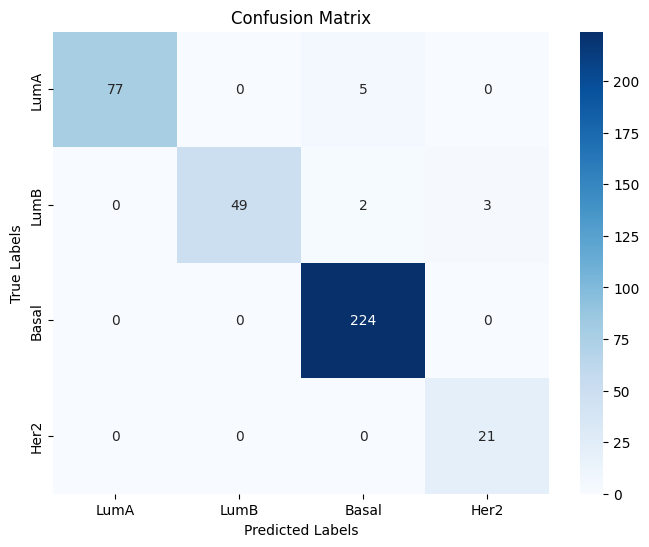

In [22]:
from sklearn.metrics import f1_score as sklearn_f1_score
n_clusters = 4
kmeans_metabric = KMeans(n_clusters=n_clusters, random_state=42)
predicted_clusters_metabric = kmeans_metabric.fit_predict(embeddings_metabric)
cluster_centers = kmeans_metabric.cluster_centers_
class_maps = {0: "LumA", 1: "LumB", 2: "Basal", 3: "Her2"}

subtype_centroids = {}
for i in range(n_clusters):
    idx = np.where(predicted_clusters_metabric == i)[0]
    subtype_centroids[i] = np.mean(embeddings_metabric[idx], axis=0)

cluster_labels = []
for center in cluster_centers:
    distances = {label: cosine_similarity([center], [centroid])[0][0]
                 for label, centroid in subtype_centroids.items()}
    cluster_labels.append(min(distances, key=distances.get))

predicted_labels_metabric = [cluster_labels[cluster] for cluster in predicted_clusters_metabric]
true_labels_metabric = [class_maps[label] for label in predicted_clusters_metabric]
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_metabric, true_labels_metabric, test_size=0.2, random_state=42
)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = sklearn_f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['LumA', 'LumB', 'Basal', 'Her2']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['LumA', 'LumB', 'Basal', 'Her2'],
            yticklabels=['LumA', 'LumB', 'Basal', 'Her2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()